In [166]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import matplotlib.ticker as mticker
import yfinance as yf
yf.pdr_override()

In [167]:
inicio = dt.date(2018, 1, 1)
final = dt.date(2022, 12, 31)

portifolio = ["ITUB3", "WEGE3", "MGLU3", "SOMA3"]
portifolio = [acao + ".SA" for acao in portifolio]

precos = yf.download(portifolio, start = inicio, end = final)['Adj Close']

[*********************100%***********************]  4 of 4 completed


In [168]:
retornos = precos.pct_change().apply(lambda x: np.log(1+x)).dropna()
media_retornos = retornos.mean()
matriz_cov = retornos.cov()

In [169]:
numero_carteiras = 100000
vetor_retornos_esperados = np.zeros(numero_carteiras)
vetor_volatilidades_esperadas = np.zeros(numero_carteiras)
vetor_sharpe = np.zeros(numero_carteiras)
vetor_pesos = np.zeros((numero_carteiras, len(portifolio)))

In [170]:
for k in range(numero_carteiras):

    pesos = np.random.random(len(portifolio))
    pesos = pesos / np.sum(pesos)

    vetor_pesos[k, :] = pesos
    
    vetor_retornos_esperados[k] = np.sum(media_retornos * pesos * 252)
    vetor_volatilidades_esperadas[k] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov*252, pesos)))

    vetor_sharpe[k] = vetor_retornos_esperados[k] / vetor_volatilidades_esperadas[k]

In [171]:
indice_sharpe_maximo = vetor_sharpe.argmax()
vetor_pesos[indice_sharpe_maximo]

array([0.03979829, 0.00383114, 0.00767463, 0.94869595])

## Criando fronteira de eficiência

In [172]:
vetor_retornos_esperados_arit = np.exp(vetor_retornos_esperados) - 1

In [173]:
eixo_y_fronteira_eficiente = np.linspace(vetor_retornos_esperados_arit.min(),
                                         vetor_retornos_esperados_arit.max(), 50)
eixo_x_fronteira_eficiente = []

In [174]:
def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos * peso_teste) * 252
    retorno = np.exp(retorno) - 1

    return retorno

def checando_soma_pesos(peso_teste):

    return np.sum(peso_teste) - 1

def pegando_volatilidade(peso_teste):
    peso_teste = np.array(peso_teste)
    volatilidade = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov*252, peso_teste)))

    return volatilidade

In [175]:
peso_inicial = [1/len(portifolio)] * len(portifolio)
limites = tuple([(0, 1) for ativo in portifolio])

In [176]:
for retorno_possivel in eixo_y_fronteira_eficiente:

    restricoes = ({"type": "eq", "fun": checando_soma_pesos},
                  {"type": "eq", "fun": lambda w: pegando_retorno(w) - retorno_possivel})

    result = minimize(pegando_volatilidade, peso_inicial, method="SLSQP", bounds = limites, constraints = restricoes)
    
    eixo_x_fronteira_eficiente.append(result["fun"])

## Plotando Gráfico

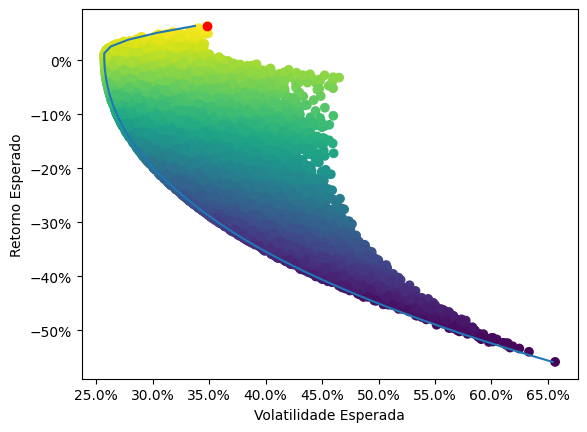

In [177]:
fig, ax = plt.subplots()

ax.scatter(vetor_volatilidades_esperadas, vetor_retornos_esperados_arit, c = vetor_sharpe)

ax.plot(eixo_x_fronteira_eficiente, eixo_y_fronteira_eficiente)

ax.scatter(vetor_volatilidades_esperadas[indice_sharpe_maximo],
           vetor_retornos_esperados_arit[indice_sharpe_maximo], c = "red")


ax.xaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

plt.xlabel("Volatilidade Esperada")
plt.ylabel("Retorno Esperado")

plt.show()